In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

# Plot sc proportions vs flow proportions

#### Load single cell data

In [3]:
def get_proportions_df(adata,ct_key="level1",pool_regions=False,regions=None,condition=None):
    """
    """
    
    a = adata
    if condition:
        a = a[a.obs["condition"]==condition]
    if regions:
        a = a[a.obs["region"].isin(regions)]
    
    df = pd.crosstab(a.obs["region"],a.obs[ct_key]).copy()
    df = df.div(df.sum(axis=1), axis=0)
    
    if pool_regions:
        df = pd.DataFrame(index=["pooled"],data={col:perc for col,perc in df.mean().iteritems()})
        df.index.name = "region"
        df.columns.name = ct_key 

    df.index = df.index.astype(str)
    df.columns = df.columns.astype(str)
    df = df.reset_index()
    df = df.melt(id_vars='region')
    df = df.rename(columns={'value': 'perc', ct_key: 'celltype'})
    if condition:
        df["condition"] = condition
    
    return df

In [4]:
# get cell count table and colors
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')
adata.obs['region'] = adata.obs['region'].cat.rename_categories({'Skull': 'Calvaria'})

In [5]:
bones = ["Calvaria","Vertebra","Scapula","Humerus","Pelvis","Femur"]
df = get_proportions_df(adata,ct_key="level1",pool_regions=True,regions=bones,condition="Naive")

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_14709/2965889694.py:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  df = pd.DataFrame(index=["pooled"],data={col:perc for col,perc in df.mean().iteritems()})


In [6]:
df

,region,celltype,perc,condition
0,pooled,progenitors,0.029428,Naive
1,pooled,neutrophil,0.286633,Naive
2,pooled,monocyte,0.046380,Naive
3,pooled,B cell,0.130531,Naive
4,pooled,T cell,0.009662,Naive
5,pooled,NK cell,0.007119,Naive
6,pooled,NK-T cell,0.006588,Naive
7,pooled,dendritic cell,0.014701,Naive
8,pooled,macrophage,0.001184,Naive
9,pooled,erythroid precursor,0.153717,Naive


In [7]:
CD45_cts = [
    'progenitors',
    'neutrophil',
    'monocyte',
    'B cell',
    'T cell',
    'NK cell',
    'NK-T cell',
    'dendritic cell',
    'macrophage',
    #'microglia', --> filtered out because we don't have brain
    #'erythroid precursor',
    #'erythroid cell',
    'basophil',
    #'structural cell',
    #'brain cell',
    'megakaryocyte',
    'innate lymphoid cell',
]

aggregation_info = {
    #aggregation name       :  flow cell type                    , reference   , annotation level of, celltypes in scRNAseq
    "Erythrocyte progenitor": ['Erythrocyte(progenitor) (% alive)' , "all"       , "level1", ['erythroid precursor']                                    ],
    "CD45+"                 : ['CD45+ (% alive)'                   , "all"       , "level1", CD45_cts                                                   ],
    "T cell"                : ['T-cells (%CD45+)'                  , "CD45+"     , "level1", ["T cell"]                                                 ],
    "NK cell"               : ['NK-cells (%CD45+)'                 , "CD45+"     , "level1", ["NK cell"]                                                ],
    "B cell"                : ['B-cells (%CD45+)'                  , "CD45+"     , "level1", ["B cell"]                                                 ],
    "Immature B cell"       : ['immature B-cells (%Bcells)'        , "B cell"    , "level2", ['pro B cell','pre B cell', 'immature B cell']             ],
    "Mature B cell"         : ['mature B-cells (%Bcells)'          , "B cell"    , "level2", ['mature B cell']                                          ],
    "Monocytes"             : ['Monocytes (%CD45+)'                , "CD45+"     , "level1", ['monocyte']                                               ],
    "Early Neutrophil"      : ['early neutrophils (%neutrophils)'  , "Neutrophil", "level2", ['pro neutrophil', 'pre neutrophil', 'immature neutrophil']],
    "Late Neutrophil"       : ['late neutrophils (%neutrophils)'   , "Neutrophil", "level2", ['mature neutrophil']                                      ],
    #None                    : ['eosinophils (%CD45+)'              , None        , "level1", None                                                       ],
    'HSC'                   : ['LSK (%CD45+)'                      , "CD45+"     , "level2", ['hematopoietic stem cell']                                ],
    "Neutrophil"            : ['neutrophils (%CD45+)'              , "CD45+"     , "level1", ['neutrophil']                                             ],
}

references_to_level1 = {
    "all"       : [adata.obs["level1"].cat.categories.tolist(), "level1"]  ,
    "CD45+"     : [CD45_cts                                   , "level1"]  ,
    "B cell"    : [["B cell"]                                 , "level1"]  ,
    "Neutrophil": [["neutrophil"]                             , "level1"]  ,
}


In [8]:
def get_cond_sample_region_from_idx(idx):
    """
    """

    # condition
    if "naive" in idx:
        cond = "Naive"
    elif "SHAM" in idx:
        cond = "Sham"
    elif "MCAO" in idx:
        cond = "MCAo"
    else: # for samples Specimen_001_blood_015.fcs, Specimen_001_femur_002.fcs, Specimen_001_skull  seq_003_008.fcs, Specimen_001_spleen 3_011.fcs, Specimen_001_spleen_003.fcs, Specimen_001_vertebra  seq_002_007.fcs
        cond = "Naive"
        
    # sample
    SAMPLES = ["naive 1", "naive 2", "naive 3", "SHAM1", "SHAM2", "SHAM3", "MCAO1", "MCAO2", "MCAO3"]
    SPECIAL_SAMPLES = {
        'Specimen_001_blood_015.fcs'             :"naive ?",
        'Specimen_001_femur_002.fcs'             :"naive ?",
        'Specimen_001_skull  seq_003_008.fcs'    :"naive ?",
        'Specimen_001_spleen 3_011.fcs'          :"naive ?",
        'Specimen_001_spleen_003.fcs'            :"naive ??",
        'Specimen_001_vertebra  seq_002_007.fcs' :"naive ?",
    }
    sample = None
    for s in SAMPLES:
        
        if idx in SPECIAL_SAMPLES:
            sample = SPECIAL_SAMPLES[idx]
        # No sample info:
        #Specimen_001_blood_015.fcs
        #
        #Specimen_001_femur_002.fcs
        #Specimen_001_skull  seq_003_008.fcs
        #
        #Specimen_001_spleen 3_011.fcs
        #Specimen_001_spleen_003.fcs
        #Specimen_001_vertebra  seq_002_007.fcs
        
        elif s in idx:
            sample = s
            
    # region
    REGIONS = {"blood": "Blood", "spleen":"Spleen", "femur":"Femur", "skull":"Calvaria", "vertebra":"Vertebra", "vertebtra":"Vertebra"}
    region = None
    for r_data, r in REGIONS.items():
        if r_data in idx:
            region = r
        
    return cond, sample, region

In [9]:
flow_bones = ["Calvaria","Vertebra","Femur"] #,"Scapula","Humerus","Pelvis"
cond_to_flow_cond = {"Naive":"naive", "Sham":"SHAM", "MCAO":"MCAO"}
#df = pd.DataFrame(index = [key for key in aggregation_info.keys()], columns=["perc sc", "perc flow", "std flow", "region", "condition"])

df_rows = []

for condition in ["Naive", "Sham", "MCAO"]:
    
    
    means_sc = {}
    #for ref, (cts, level) in references_to_level1.items():
    for _, aggr_info in aggregation_info.items():
        _, ref, level_for_cts, _ = aggr_info
        cts, level_for_ref = references_to_level1[ref]
        df_sc = get_proportions_df(adata[adata.obs[level_for_ref].isin(cts)],ct_key=level_for_cts,pool_regions=False,regions=flow_bones,condition=condition)
        means_sc[f"{ref}_{level_for_cts}"] = df_sc.groupby(["region","celltype"]).mean()

    # Load and process flow df
    df_flow = pd.read_excel(DATA_DIR+'221019_FACS/20221014_Ilgin_newEO.xlsx', index_col=0, sheet_name=cond_to_flow_cond[condition])
    df_flow["neutrophils (%CD45+)"] = df_flow[['early neutrophils (%CD45+)', 'late neutrophils (%CD45+)']].sum(axis=1)
    df_flow = df_flow.rename(columns={'early neutrophils (%CD45+)': 'early neutrophils (%neutrophils)', 'late neutrophils (%CD45+)': 'late neutrophils (%neutrophils)'})
    df_flow[['early neutrophils (%neutrophils)', 'late neutrophils (%neutrophils)']] *= (100/df_flow["neutrophils (%CD45+)"].values[:,np.newaxis])
    df_flow = df_flow/100
        
    #for key in dfs:
    #    df_flow["region"] = [v[2] for v in df_flow.index.to_series().apply(get_cond_sample_region_from_idx).values]
    df_flow["region"] = [v[2] for v in df_flow.index.to_series().apply(get_cond_sample_region_from_idx).values]
        
    df_flow = df_flow.loc[df_flow["region"].isin(flow_bones)]#["Femur","Calvaria","Vertebra"])]
    df_flow_std = df_flow.groupby("region").std()
    df_flow = df_flow.groupby("region").mean()
    
    for ct, aggr_info in aggregation_info.items():
        
        for region in flow_bones:
            
            df_rows.append([
                ct,
                means_sc[f"{aggr_info[1]}_{aggr_info[2]}"].loc[region].loc[aggr_info[3]].sum()[0],
                df_flow.loc[region,aggr_info[0]], 
                df_flow_std.loc[region,aggr_info[0]], 
                region, 
                condition
            ])
        

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_14709/3584619906.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_sc[f"{ref}_{level_for_cts}"] = df_sc.groupby(["region","celltype"]).mean()
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_14709/3584619906.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_sc[f"{ref}_{level_for_cts}"] = df_sc.groupby(["region","celltype"]).mean()
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_14709/3584619906.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, n

In [10]:
def get_color(adata, obs_key, category):
    """
    """
    idx = adata.obs[obs_key].cat.categories.tolist().index(category)
    return adata.uns[f"{obs_key}_colors"][idx]

In [11]:
df = pd.DataFrame(df_rows, columns=["ct", "perc sc", "perc flow", "std flow", "region", "condition"])

condition_color = {c: get_color(adata, "condition", c) for c in ["Naive", "Sham", "MCAO"]}
region_color = {b: get_color(adata, "region", b) for b in flow_bones}
ct_color = {
    'Erythrocyte progenitor':get_color(adata, "level1", 'erythroid precursor'),
    'CD45+'                 :get_color(adata, "level1", 'structural cell'),
    'T cell'                :get_color(adata, "level1", 'T cell'),
    'NK cell'               :get_color(adata, "level1", 'NK cell'),
    'B cell'                :'darkblue',#'darkturquoise',#get_color(adata, "level1", 'B cell'),
    'Immature B cell'       :get_color(adata, "level2", 'immature B cell'),
    'Mature B cell'         :get_color(adata, "level2", 'mature B cell'),
    'Monocytes'             :get_color(adata, "level1", 'monocyte'),
    'Early Neutrophil'      :get_color(adata, "level2", 'immature neutrophil'),
    'Late Neutrophil'       :get_color(adata, "level2", 'mature neutrophil'),
    'HSC'                   :get_color(adata, "level2", 'hematopoietic stem cell'),
    'Neutrophil'            :'black',#'darkolivegreen',#'black',#get_color(adata, "level1", 'neutrophil'),
}

df["condition_color"] = [condition_color[c] for c in df["condition"]]
df["region_color"] = [region_color[r] for r in df["region"]]
df["ct_color"] = [ct_color[c] for c in df["ct"]]

In [ ]:
df.head()

,ct,perc sc,perc flow,std flow,region,condition,condition_color,region_color,ct_color
0,Erthrocyte progenitor,0.079968,0.34025,0.089164,Calvaria,Naive,#ff7f0e,#e377c2,#B67A6E
1,Erthrocyte progenitor,0.130233,0.28925,0.135278,Vertebra,Naive,#ff7f0e,#b5bd61,#B67A6E
2,Erthrocyte progenitor,0.203475,0.35725,0.138303,Femur,Naive,#ff7f0e,#ff7f0e,#B67A6E
3,CD45+,0.571284,0.63425,0.090772,Calvaria,Naive,#ff7f0e,#e377c2,#e86711
4,CD45+,0.553779,0.67050,0.127639,Vertebra,Naive,#ff7f0e,#b5bd61,#e86711


In [14]:
from sklearn.linear_model import LinearRegression
#X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])

#y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(df["perc flow"].values[:,np.newaxis], df["perc sc"].values)
#reg.score(df["perc flow"].values[:,np.newaxis], df["perc sc"].values)

reg.coef_

reg.intercept_

reg.predict(np.array([[3], [5]]))

reg.predict(np.arange(0,1,0.1)[:,np.newaxis])

array([0.00592393, 0.10079704, 0.19567015, 0.29054326, 0.38541637,
       0.48028948, 0.57516259, 0.6700357 , 0.7649088 , 0.85978191])

In [15]:
from scipy.stats import linregress

linregress(df["perc sc"].values, df["perc flow"].values)#(np.arange(0,1))

LinregressResult(slope=0.8001051315589784, intercept=0.0710176967051187, rvalue=0.8712546217450631, pvalue=1.5334543307672745e-34, stderr=0.04378055825407519, intercept_stderr=0.018298033057605544)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

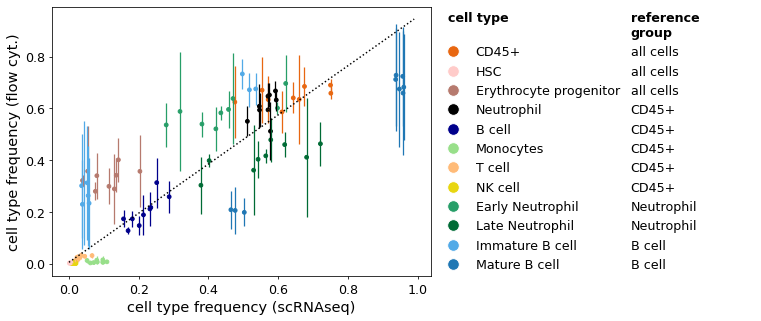

In [19]:
fig = plt.figure(figsize=(7,5))

ax = plt.gca()
ax.scatter(df["perc sc"].values, df["perc flow"].values, color=df[f"ct_color"].values, s=15)
ax.set_xlabel("cell type frequency (scRNAseq)")
ax.set_ylabel("cell type frequency (flow cyt.)")
ax.errorbar(df["perc sc"].values, df["perc flow"].values, elinewidth=1.3, fmt='none', xerr=None, yerr=df["std flow"].values, ecolor=df[f"ct_color"].values)
X = np.arange(0,1,0.01)[:,np.newaxis]
ax.plot(X, reg.predict(X), color="black", linestyle=":")

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import rc
# activate latex text rendering
#rc('text', usetex=False)

ct_order = [
    'CD45+', 'HSC', 'Erythrocyte progenitor', 'Neutrophil', 'B cell', 'Monocytes',  'T cell', 
    'NK cell', 'Early Neutrophil', 'Late Neutrophil',  'Immature B cell', 'Mature B cell'
]
ref_group = {
    'CD45+':'all cells', 'HSC':'all cells', 'Erythrocyte progenitor':'all cells', 
    'Neutrophil':'CD45+', 'B cell':'CD45+', 'Monocytes':'CD45+',  'T cell':'CD45+', 'NK cell':'CD45+', 
    'Early Neutrophil':'Neutrophil', 'Late Neutrophil':'Neutrophil',  
    'Immature B cell':'B cell', 'Mature B cell':'B cell'
}
#dots = [Line2D([0], [0], marker='o', color='w', label=ct,markerfacecolor=color, markersize=12) for ct,color in ct_color.items()]
dots = [Line2D([0], [0], marker='', color='w', label="cell type\n",markerfacecolor='w', markersize=12)]
dots+= [Line2D([0], [0], marker='o', color='w', label=ct,markerfacecolor=ct_color[ct], markersize=12) for ct in ct_order]
refs = [Line2D([0], [0], marker='', color='w', label="reference\ngroup",markerfacecolor='w', markersize=12)]
refs+= [Line2D([0], [0], marker='o', color='w', label=ref_group[ct], markerfacecolor='w', markersize=12) for ct in ct_order]
leg = plt.legend(handles=dots+refs, loc=[1.01,0.0], frameon=False, ncol=2)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children():#[:1]:
        if hpack.get_children()[1]._text.get_text() in ["cell type\n", "reference\ngroup"]:
            hpack.get_children()[1]._text.set_weight('bold')
        if hpack.get_children()[0]._children[0]._markerfacecolor == 'w':
            if hpack.get_children()[1]._text.get_text() == "cell type\n":
                hpack.get_children()[1]._text.set_position([-28,0])
            else:
                hpack.get_children()[1]._text.set_position([-50,0])
            

fig.savefig("./figures/sc_vs_flow_ct_frequencies.pdf", bbox_inches = "tight", transparent=True)



### Get correlations

In [238]:
rows = []
for cond in ["Naive", "Sham", "MCAO"]:
    for region in flow_bones:
        filt = (df["condition"] == cond) & (df["region"] == region)
        print(cond.ljust(6), region.ljust(9), f'{np.corrcoef(df.loc[filt,"perc sc"].values, df.loc[filt,"perc flow"].values)[0,1]:.3f}')
        rows.append([cond.ljust(6), region.ljust(9), f'{np.corrcoef(df.loc[filt,"perc sc"].values, df.loc[filt,"perc flow"].values)[0,1]:.3f}'])
pd.DataFrame(rows, columns=["condition", "bone", "pearson correlation"]).to_csv("./figures/sc_vs_flow_pearson_r.csv")

Naive  Calvaria  0.766
Naive  Vertebra  0.886
Naive  Femur     0.884
Sham   Calvaria  0.860
Sham   Vertebra  0.897
Sham   Femur     0.890
MCAO   Calvaria  0.863
MCAO   Vertebra  0.923
MCAO   Femur     0.905
